## Highest Score So Far:

Version: submission7.33.csv

Public Leaderboard: 0.7743

In [1]:
import pandas as pd
import numpy as np
import patsy

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from scipy import stats


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from itertools import combinations
from random import shuffle

In [2]:
# Train X and y
train_X = pd.read_csv('train_X.csv')
train_y = pd.read_csv('train_y.csv')
train = train_X.merge(train_y, on='ID')

# Test X
test_X = pd.read_csv('public_private_X.csv')

In [3]:
### --------------------- DROPPING COLUMNS THAT AREN'T USEFUL ---------------------

cols_to_drop = [
    'ID', # identification number unique to each delivery (not useful)
    'PURCHASE_ORDER_DUE_DATE', # found the datetime columns to be not useful
    'ORDER_DATE', # found the datetime columns to be not useful
    'DIVISION_NUMBER', # information is perfectly reflected in DIVISION_CODE (identical when one-hot-encoded)
    'RESERVABLE_INDICATOR', # only have one unique value
    'PRODUCT_STATUS', # only has one unique value
    'PURCHASE_ORDER_TYPE', # deemed not useful in data visualization later on
]

test_ID = test_X['ID']

train.drop(columns=cols_to_drop, inplace=True)
test_X.drop(columns=cols_to_drop, inplace=True)

### --------------------- CHANGING DTYPE OF COLUMNS ---------------------

cat_preds = [
    'DIVISION_CODE', # already categorical
    'COMPANY_VENDOR_NUMBER', # represents a vendor number, works better categorically
    'ORDER_DAY_OF_WEEK', # day of the week, works better categorically
    'DUE_DATE_WEEKDAY', # day of the week, works better categorically
    'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
]

# defining the set of numerical columns
num_preds = [col for col in train.columns if col not in cat_preds + ["ON_TIME_AND_COMPLETE"]]

In [4]:
#### ------------------- MISSING DATA IMPUTATION -------------------

# Detecting the columns with missing values
columns_missingness = train.isna().sum()[train.isna().sum() != 0].index
corr_matrix = train[num_preds].corr().abs()
# For the columns with missing values, finding which column it has the best correlation with, and building a linear regression to impute the missing values
for col in columns_missingness:
    vars_with_highest_corr = list(corr_matrix[col].drop(columns_missingness).sort_values(ascending=False).index[0:5]) # getting the five variables with the highest correlation as X in the LR
    # Building a linear regression to impute col using var_with_highest_corr
    x = train[vars_with_highest_corr]
    y = train[col]
    idx_non_missing = np.isfinite(x).all(axis=1) & np.isfinite(y)
    model = LinearRegression()
    model.fit(x[idx_non_missing], y[idx_non_missing])

    # Imputing the train data
    missing_idx_train = train[col].isna()
    train.loc[missing_idx_train, col] = model.predict(train.loc[missing_idx_train, vars_with_highest_corr])

    # Imputing the test data
    missing_idx_test = test_X[col].isna()
    test_X.loc[missing_idx_test, col] = model.predict(test_X.loc[missing_idx_test, vars_with_highest_corr])



In [146]:
### ----------------- CORRELATION MATRICES ----------------------

# Correlation with the response
high_corr_preds = train[num_preds].corrwith(train['ON_TIME_AND_COMPLETE']).abs().sort_values(ascending=False)
high_corr_preds


PRODUCT_CLASSIFICATION                   0.266281
PURCHASE_FROM_VENDOR                     0.199145
PURCHASING_LEAD_TIME                     0.164594
DAYS_BETWEEN_ORDER_AND_DUE_DATE          0.141651
TRANSIT_LEAD_TIME                        0.128883
DISTANCE_IN_MILES                        0.118058
AVERAGE_ORDER_CYCLE_DAYS                 0.112881
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    0.095015
AVERAGE_DAILY_DEMAND_CASES               0.091146
AVERAGE_VENDOR_ORDER_CYCLE_DAYS          0.075147
SHIP_FROM_VENDOR                         0.068787
LEAD_TIME_TO_DISTANCE_RATIO              0.060109
PRODUCT_MARKET                           0.018960
AVERAGE_ORDER_CYCLE_CASES                0.013371
PRODUCT_NUMBER                           0.011300
ORDER_QUANTITY_DEVIATION                 0.006848
dtype: float64

In [147]:
# Correlation with eachother
train[num_preds].corr().abs()

,PRODUCT_NUMBER,SHIP_FROM_VENDOR,PRODUCT_CLASSIFICATION,DISTANCE_IN_MILES,PURCHASE_FROM_VENDOR,AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET,ORDER_QUANTITY_DEVIATION,TRANSIT_LEAD_TIME,PURCHASING_LEAD_TIME,DAYS_BETWEEN_ORDER_AND_DUE_DATE,PRODUCT_MARKET,AVERAGE_DAILY_DEMAND_CASES,AVERAGE_VENDOR_ORDER_CYCLE_DAYS,AVERAGE_ORDER_CYCLE_DAYS,AVERAGE_ORDER_CYCLE_CASES,LEAD_TIME_TO_DISTANCE_RATIO
PRODUCT_NUMBER,1.000000,0.005264,0.002122,0.043117,0.010871,0.002290,0.005411,0.006312,0.009646,0.010721,0.008129,0.000417,0.009612,0.009793,0.005730,0.030950
SHIP_FROM_VENDOR,0.005264,1.000000,0.092989,0.131653,0.126755,0.063810,0.012892,0.035595,0.006878,0.023651,0.001140,0.037157,0.072686,0.048783,0.050098,0.009378
PRODUCT_CLASSIFICATION,0.002122,0.092989,1.000000,0.088515,0.196703,0.173054,0.013208,0.303764,0.349758,0.331980,0.002885,0.019493,0.038611,0.094599,0.047533,0.076892
DISTANCE_IN_MILES,0.043117,0.131653,0.088515,1.000000,0.104695,0.115278,0.015147,0.226557,0.310640,0.281977,0.013792,0.002246,0.095757,0.095224,0.048163,0.335303
PURCHASE_FROM_VENDOR,0.010871,0.126755,0.196703,0.104695,1.000000,0.040364,0.020624,0.237484,0.282103,0.271507,0.009170,0.087680,0.001549,0.042926,0.037198,0.054667
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET,0.002290,0.063810,0.173054,0.115278,0.040364,1.000000,0.002950,0.084835,0.132126,0.118822,0.013495,0.556926,0.102768,0.080656,0.745930,0.000126
ORDER_QUANTITY_DEVIATION,0.005411,0.012892,0.013208,0.015147,0.020624,0.002950,1.000000,0.004728,0.001467,0.001871,0.006140,0.004880,0.008207,0.011136,0.004142,0.001769
TRANSIT_LEAD_TIME,0.006312,0.035595,0.303764,0.226557,0.237484,0.084835,0.004728,1.000000,0.864590,0.853955,0.005854,0.052579,0.043033,0.061636,0.008131,0.044198
PURCHASING_LEAD_TIME,0.009646,0.006878,0.349758,0.310640,0.282103,0.132126,0.001467,0.864590,1.000000,0.957562,0.013428,0.049776,0.112348,0.126438,0.043944,0.068295
DAYS_BETWEEN_ORDER_AND_DUE_DATE,0.010721,0.023651,0.331980,0.281977,0.271507,0.118822,0.001871,0.853955,0.957562,1.000000,0.011266,0.057607,0.108241,0.120202,0.030589,0.071999


In [148]:
### ---------------------- OUTLIER IMPUTATION CLASS -----------------------

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, target_column=None, method='iqr', iqr_multiplier=1.5, strategy='clip'):
        self.columns = columns
        self.target_column = target_column
        self.method = method
        self.iqr_multiplier = iqr_multiplier
        self.strategy = strategy
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)

        # Exclude the response variable from feature selection
        if self.target_column and self.target_column in X.columns:
            X_features = X.drop(columns=[self.target_column])
        else:
            X_features = X

        # Use all numerical columns if none are specified
        if self.columns is None:
            self.columns = X_features.select_dtypes(include=np.number).columns.tolist()

        self.bounds_ = {}
        for col in self.columns:
            Q1 = X_features[col].quantile(0.25)
            Q3 = X_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.iqr_multiplier * IQR
            upper_bound = Q3 + self.iqr_multiplier * IQR
            self.bounds_[col] = (lower_bound, upper_bound)

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        # Apply outlier handling only to selected feature columns
        for col in self.columns:
            lower_bound, upper_bound = self.bounds_[col]

            if self.strategy == 'median':
                median_value = X[col].median()
                X[col] = np.where((X[col] < lower_bound) | (X[col] > upper_bound), median_value, X[col])

            elif self.strategy == 'mean':
                mean_value = X[col].mean()
                X[col] = np.where((X[col] < lower_bound) | (X[col] > upper_bound), mean_value, X[col])

            elif self.strategy == 'clip':
                X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)
            
            elif self.strategy == 'none':
                X[col] = X[col]

        return X


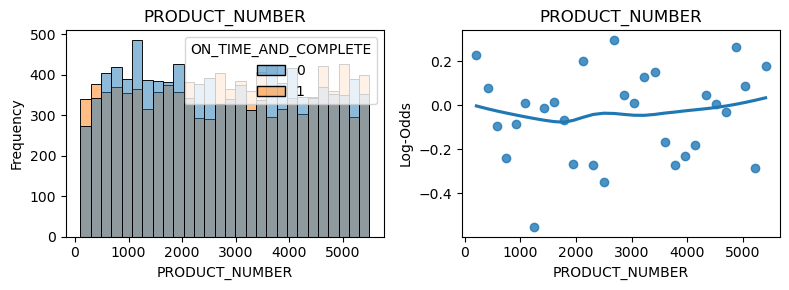

/Users/hayden/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


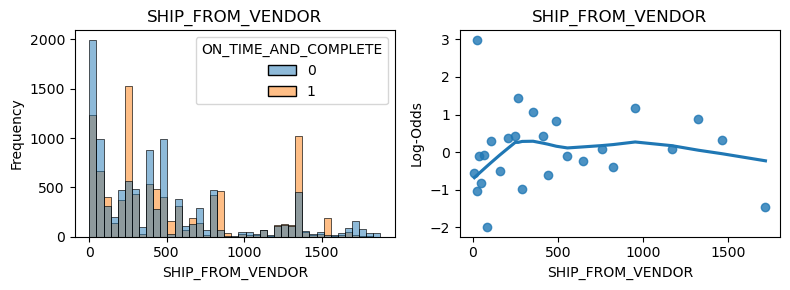

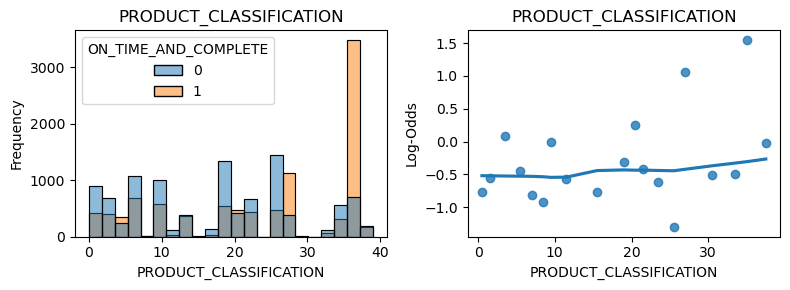

/Users/hayden/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


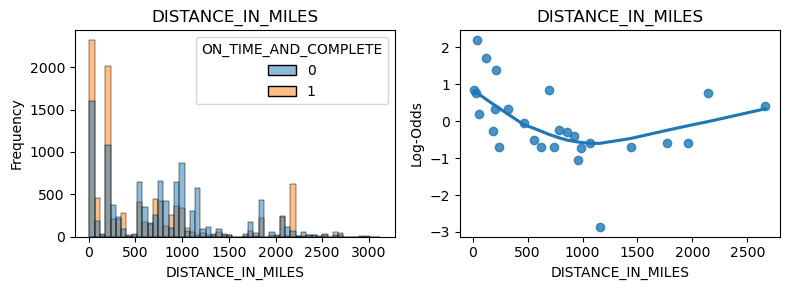

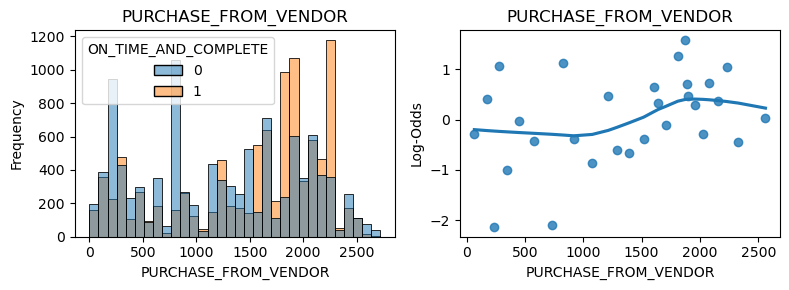

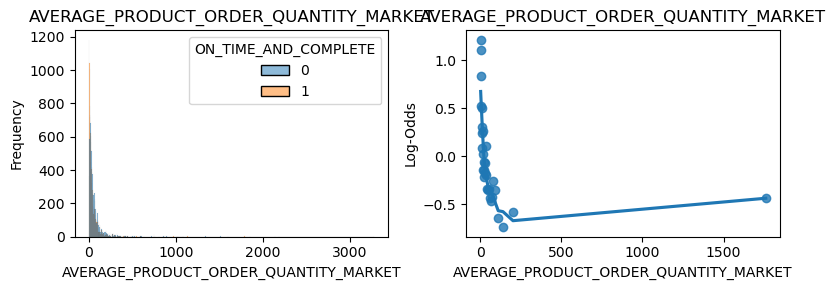

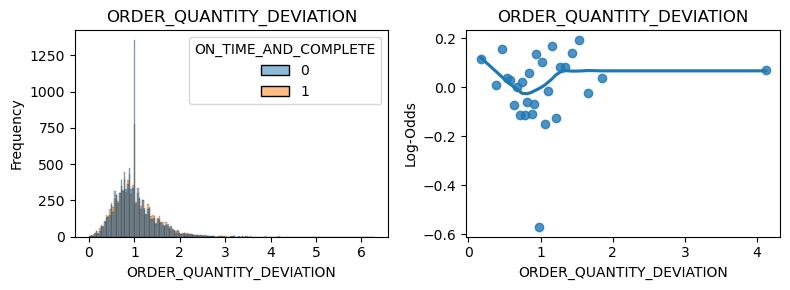

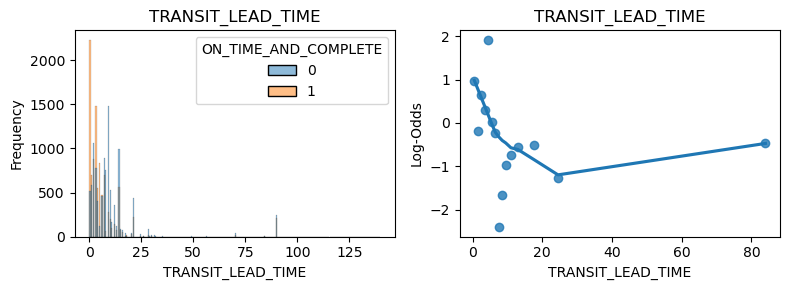

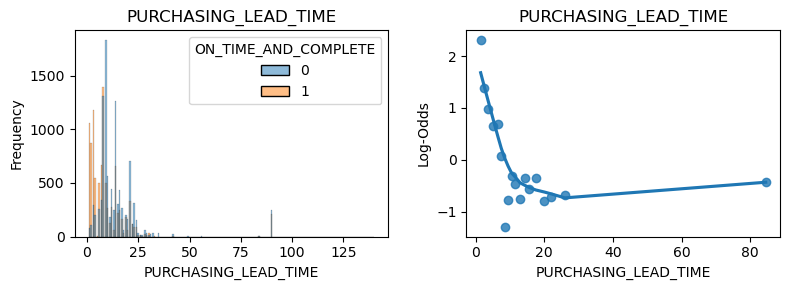

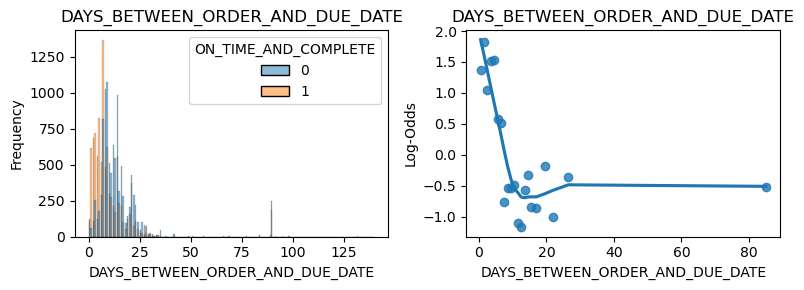

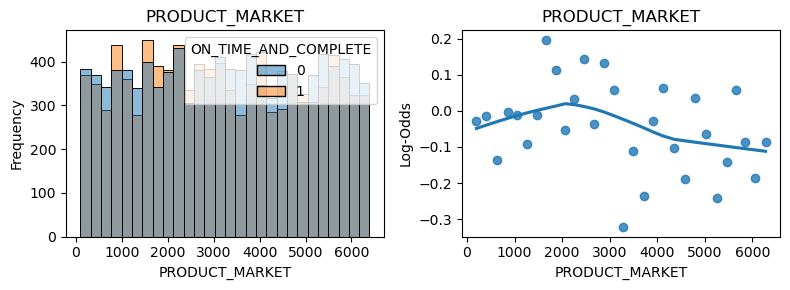

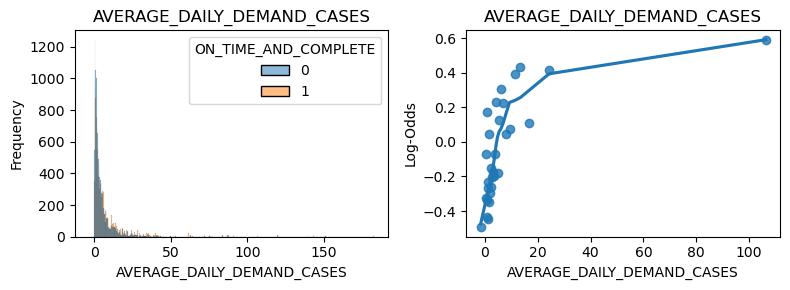

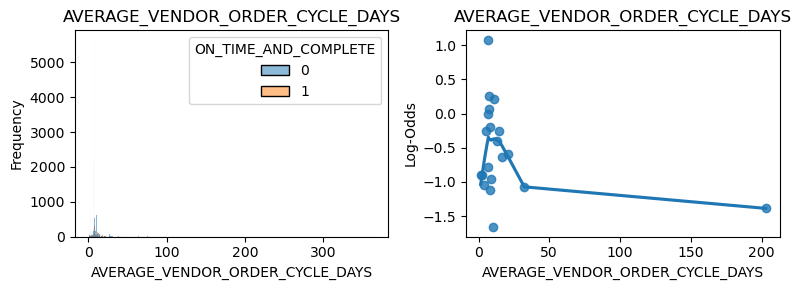

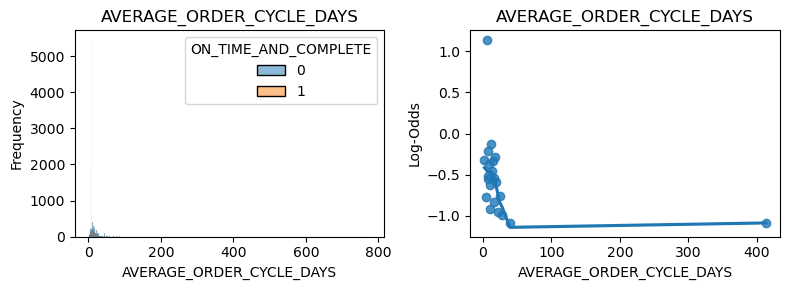

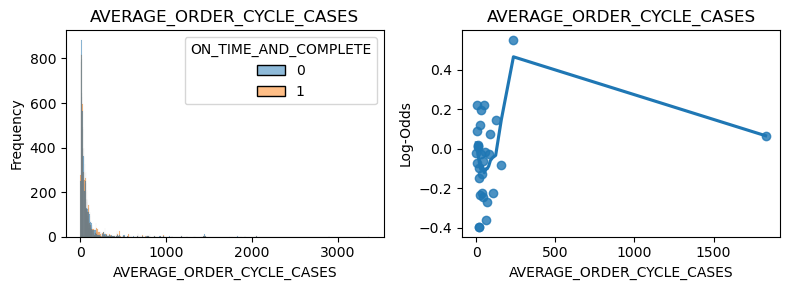

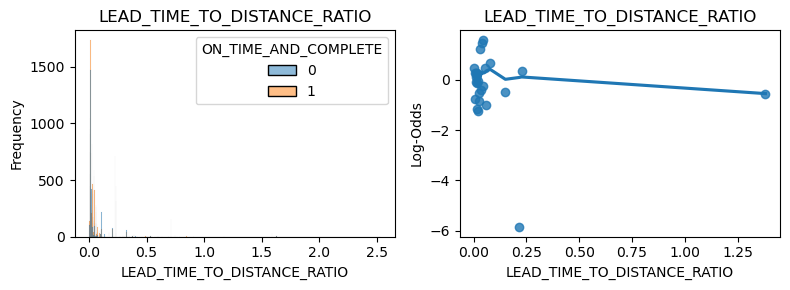

In [130]:
### ----------------- DATA VIZ -----------------

train_viz = train.copy()

# function to estimate log-odds of a group
def compute_log_odds(df, predictor, response, bins=30):
    df['bin'] = pd.qcut(df[predictor], q=bins, duplicates='drop') # Binning the data to get a better approximation of the relationship
    grouped = df.groupby('bin', observed=False)[response].agg(['mean'])
    
    # Compute log odds
    grouped['log_odds'] = np.log(grouped['mean'] / (1 - grouped['mean']))
    
    return grouped

# visualizing the histogram and log-odds plot of each
for col in num_preds:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Histogram of predictor on train data
    sns.histplot(data = train_viz, x=col, ax=axes[0], hue='ON_TIME_AND_COMPLETE')
    axes[0].set_title(f'{col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Computing log odds for the column
    log_odds_data = compute_log_odds(train_viz, col, 'ON_TIME_AND_COMPLETE')

    # Scatterplot with trendline (regplot) of predictor on train predictor
    sns.regplot(x = log_odds_data.index.categories.mid, y = log_odds_data['log_odds'], ax=axes[1], scatter=True, lowess=True) # lowess=True allows for a non-linear trendline to be shown
    axes[1].set_title(f'{col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Log-Odds')    

    # Showing the plots
    plt.tight_layout()
    plt.show()

In [5]:
### ---------------- VARIABLE TRANSFORMATIONS ----------------

log_preds = [
    #'SHIP_FROM_VENDOR',
    'DISTANCE_IN_MILES',
    'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET',
    'TRANSIT_LEAD_TIME',
    'PURCHASING_LEAD_TIME',
    'DAYS_BETWEEN_ORDER_AND_DUE_DATE',
    'AVERAGE_DAILY_DEMAND_CASES',
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS',
    'AVERAGE_ORDER_CYCLE_DAYS',
    'AVERAGE_ORDER_CYCLE_CASES',
    'LEAD_TIME_TO_DISTANCE_RATIO',
    'ORDER_QUANTITY_DEVIATION',
]

train_logged = train.copy()
test_X_logged = test_X.copy()

def log_transformation(X):
    X = np.where(X <= -1, 0.999, X) # making sure to not pass negative values to the logorithm
    return np.log1p(X)

for col in log_preds:
    train_logged[col] = log_transformation(train[col])
    test_X_logged[col] = log_transformation(test_X_logged[col])



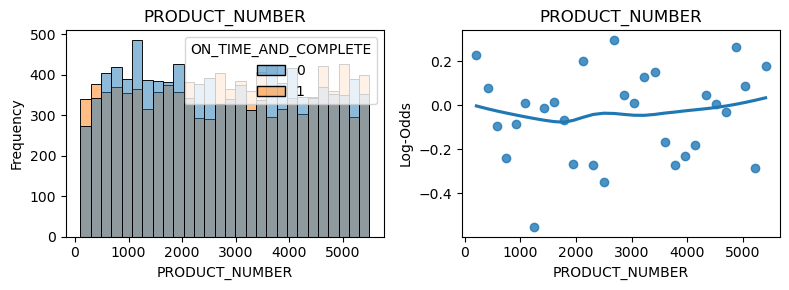

/Users/hayden/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


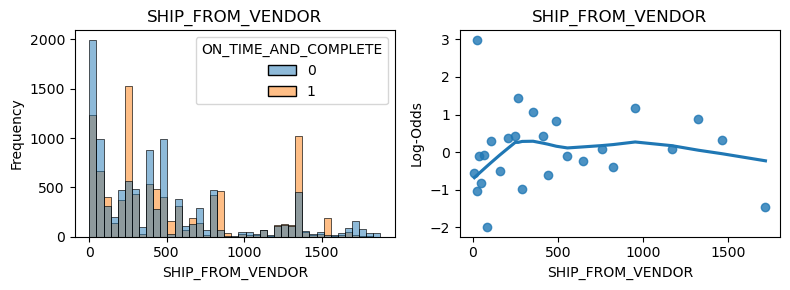

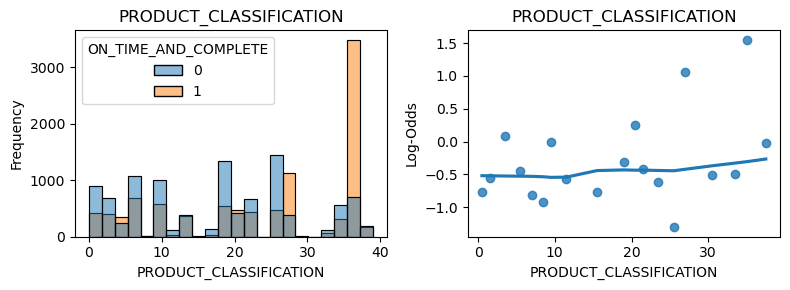

/Users/hayden/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


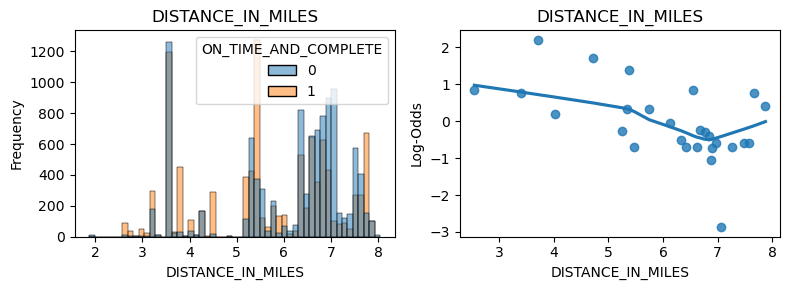

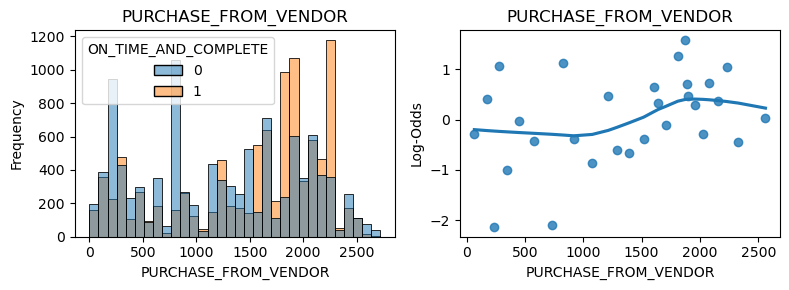

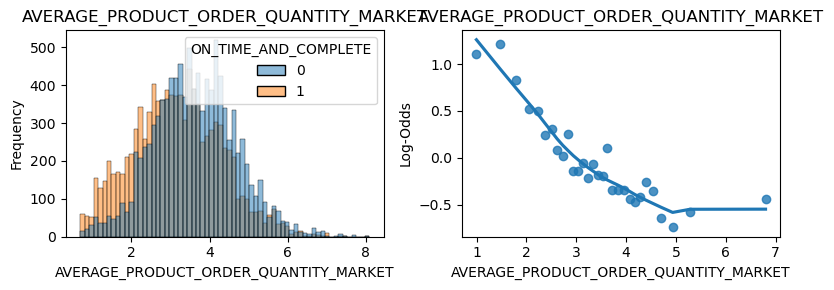

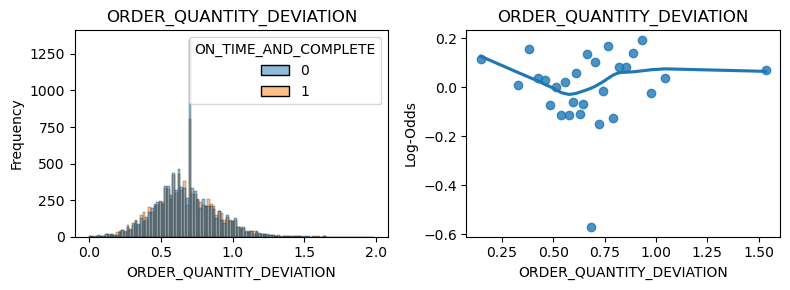

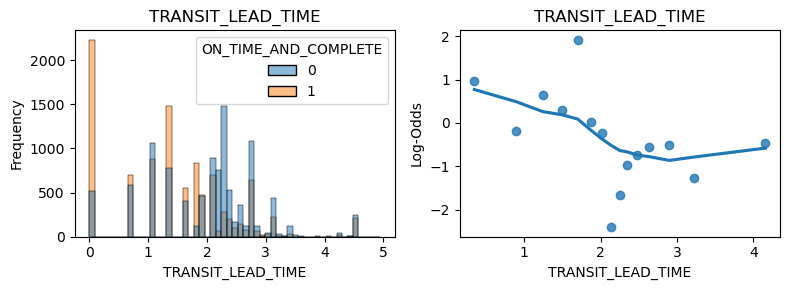

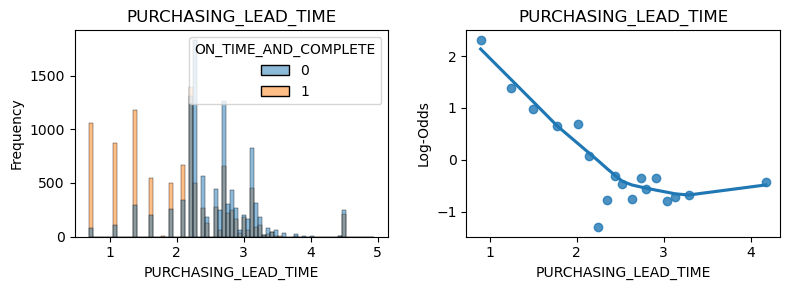

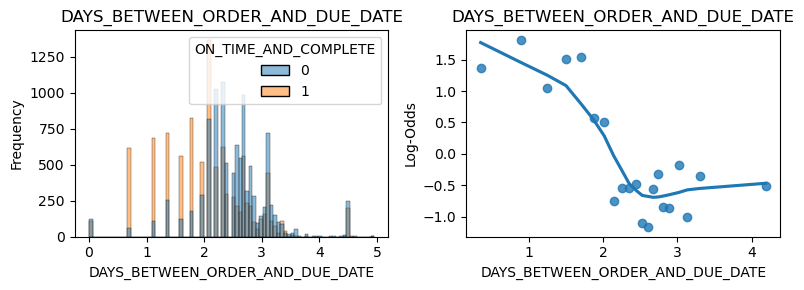

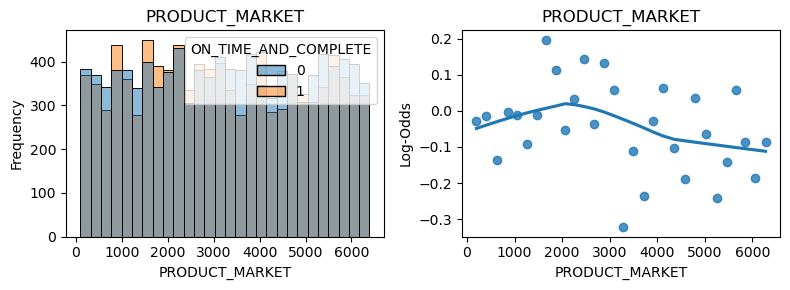

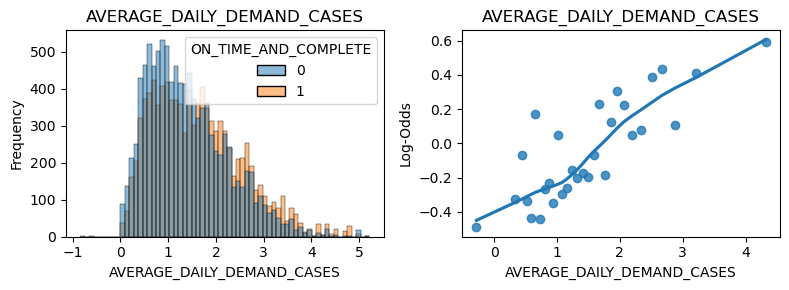

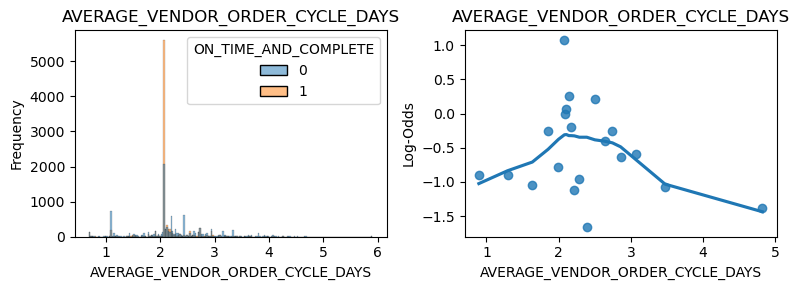

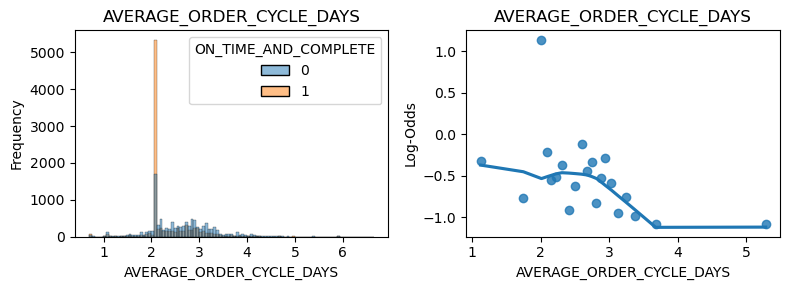

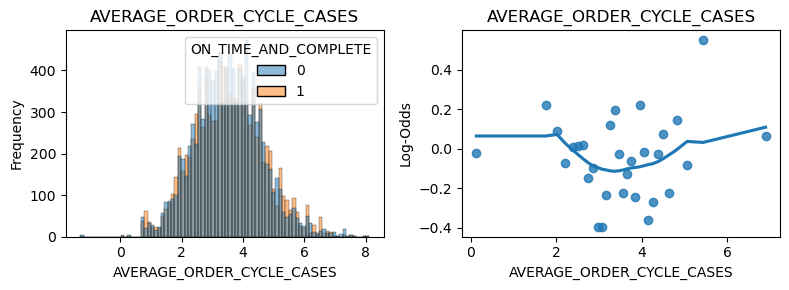

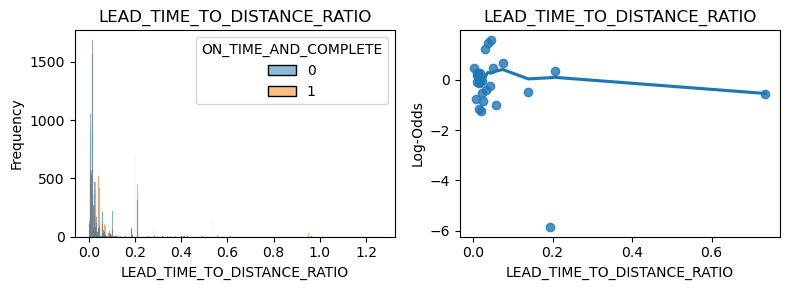

In [67]:
### ----- VIZ AGAIN -----

train_viz2 = train_logged.copy()

# visualizing the histogram and log-odds plot of each
for col in num_preds:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Histogram of predictor on train data
    sns.histplot(data = train_viz2, x=col, ax=axes[0], hue='ON_TIME_AND_COMPLETE')
    axes[0].set_title(f'{col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Computing log odds for the column
    log_odds_data = compute_log_odds(train_viz2, col, 'ON_TIME_AND_COMPLETE')

    # Scatterplot with trendline (regplot) of predictor on train predictor
    sns.regplot(x = log_odds_data.index.categories.mid, y = log_odds_data['log_odds'], ax=axes[1], scatter=True, lowess=True) # lowess=True allows for a non-linear trendline to be shown
    axes[1].set_title(f'{col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Log-Odds')    

    # Showing the plots
    plt.tight_layout()
    plt.show()

In [150]:
avg_vend_days_df = pd.DataFrame(train_logged['AVERAGE_VENDOR_ORDER_CYCLE_DAYS'].value_counts().sort_index())
avg_vend_days_df['prop_1'] = train_logged.groupby('AVERAGE_VENDOR_ORDER_CYCLE_DAYS')['ON_TIME_AND_COMPLETE'].mean().sort_index().values
avg_vend_days_df.iloc[320:330]

,count,prop_1
AVERAGE_VENDOR_ORDER_CYCLE_DAYS,,
2.075182,3,1.000000
2.075684,37,0.297297
2.079442,7261,0.748933
2.080191,6,0.333333
2.081564,29,0.655172
2.082811,4,0.250000
2.083185,18,0.388889
2.083309,5,0.600000
2.084056,2,0.500000


In [6]:
### ---------------- BINNING CERTAIN COLUMNS ----------------

def bin_column(col, method='auto', bins=None):
    """
    Modifies the original dataframe, creating a binned column from a numerical column and discarding the original column
    Args:
        - `col`: column to bin
        - `method`: method of binning, either auto or custom
        - `bins`: specific information on bins. If method=auto, bins should be a number. If method=custom, bins should be a list containing values for binning
    Returns: modified versions of the original dataframes with the specified column binned
    """

    # Binning according to method
    if method == 'auto':
        bins = pd.cut(train_logged[col], bins=bins, retbins=True)[1]
        train_logged[f"{col}_binned"] = pd.cut(train_logged[col], bins=bins)
        test_X_logged[f"{col}_binned"] = pd.cut(test_X_logged[col], bins=bins)
    if method == 'custom':
        train_logged[f"{col}_binned"] = pd.cut(train_logged[col], bins=bins)
        test_X_logged[f"{col}_binned"] = pd.cut(test_X_logged[col], bins=bins)
    
    # Dropping the original columns from the dataframes
    #train_logged.drop(columns = [col])
    #test_X_logged.drop(columns = [col])

    # Dropping the original column name from the num_preds list
    #num_preds.remove(col)
    
    # Adding the new binned columns to the list of categorical variables
    global cat_preds # accessing the global variable
    cat_preds = cat_preds + [f"{col}_binned"]

    return train_logged, test_X_logged

# Binning certain numerical columns
train_logged, test_X_logged = bin_column(col='DAYS_BETWEEN_ORDER_AND_DUE_DATE', method='auto', bins=10) 
train_logged, test_X_logged = bin_column(col='AVERAGE_ORDER_CYCLE_DAYS', method='custom', bins=[-1, 2.079, 2.0795, 7]) 
train_logged, test_X_logged = bin_column(col='DISTANCE_IN_MILES', method='auto', bins=20)
#train_logged, test_X_logged = bin_column(col='AVERAGE_VENDOR_ORDER_CYCLE_DAYS', method='custom', bins=[0, 0.5, 1, 1.5, 2.079, 2.0795, 2.5, 3, 3.5, 4, 4.5, 5, 7 ])
#train_logged, test_X_logged = bin_column(col='SHIP_FROM_VENDOR', method='auto', bins=10)
#train_logged, test_X_logged = bin_column(col='PRODUCT_CLASSIFICATION', method='auto', bins=20)
train_logged, test_X_logged = bin_column(col='PURCHASE_FROM_VENDOR', method='auto', bins=10)
#train_logged, test_X_logged = bin_column(col='AVERAGE_ORDER_CYCLE_CASES', method='auto', bins=15)
#train_logged, test_X_logged = bin_column(col='PURCHASING_LEAD_TIME', method='auto', bins=20)
train_logged, test_X_logged = bin_column(col='TRANSIT_LEAD_TIME', method='auto', bins=15) 
#train_logged, test_X_logged = bin_column(col='PRODUCT_MARKET', method='auto', bins=10) 
#train_logged, test_X_logged = bin_column(col='ORDER_QUANTITY_DEVIATION', method='auto', bins=15) 







In [152]:
num_preds

['PRODUCT_NUMBER',
 'SHIP_FROM_VENDOR',
 'PRODUCT_CLASSIFICATION',
 'DISTANCE_IN_MILES',
 'PURCHASE_FROM_VENDOR',
 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET',
 'ORDER_QUANTITY_DEVIATION',
 'TRANSIT_LEAD_TIME',
 'PURCHASING_LEAD_TIME',
 'DAYS_BETWEEN_ORDER_AND_DUE_DATE',
 'PRODUCT_MARKET',
 'AVERAGE_DAILY_DEMAND_CASES',
 'AVERAGE_VENDOR_ORDER_CYCLE_DAYS',
 'AVERAGE_ORDER_CYCLE_DAYS',
 'AVERAGE_ORDER_CYCLE_CASES',
 'LEAD_TIME_TO_DISTANCE_RATIO']

In [153]:
cat_preds

['DIVISION_CODE',
 'COMPANY_VENDOR_NUMBER',
 'ORDER_DAY_OF_WEEK',
 'DUE_DATE_WEEKDAY',
 'GIVEN_TIME_TO_LEAD_TIME_RATIO',
 'DAYS_BETWEEN_ORDER_AND_DUE_DATE_binned',
 'AVERAGE_ORDER_CYCLE_DAYS_binned',
 'DISTANCE_IN_MILES_binned',
 'PURCHASE_FROM_VENDOR_binned',
 'TRANSIT_LEAD_TIME_binned']

In [7]:
### ------------------- PIPELINE -------------------

num_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_preds),
    ('cat', cat_pipeline, cat_preds)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=0.25, n_jobs=-1))
])

In [8]:
### ------------------- FITTING THE MODEL (TRAIN-TEST SPLIT) -------------------

# Train-test split
X = train_logged.drop(columns=['ON_TIME_AND_COMPLETE'])
y = train_logged['ON_TIME_AND_COMPLETE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Fitting the model
model_split = pipeline.fit(X_train, y_train)
model_split

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PRODUCT_NUMBER',
                                                   'SHIP_FROM_VENDOR',
                                                   'PRODUCT_CLASSIFICATION',
                                                   'DISTANCE_IN_MILES',
                                                   'PURCHASE_FROM_VENDOR',
                                                   'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET',
                                                   'ORDER_QUANTITY_DEVIATION',
                                                   'TRANSIT_LEAD...
                                                   'COMPANY_VENDOR_NUMBER',
                                                   'ORDER_DAY_OF_WEEK',
                                                   'DUE_DATE_WEEKDAY',
                                                   'GIVEN_TIME_TO_LEAD_TIME_RATIO',
                                                   'DAYS_BETWEEN_ORDER_AND_DUE_DATE_binned',
                                                   'AVERAGE_ORDER_CYCLE_DAYS_binned',
                                                   'DISTANCE_IN_MILES_binned',
                                                   'PURCHASE_FROM_VENDOR_binned',
                                                   'TRANSIT_LEAD_TIME_binned'])])),
                ('model',
                 LogisticRegression(l1_ratio=0.25, max_iter=5000, n_jobs=-1,
                                    penalty='elasticnet', solver='saga'))])

In [ ]:
prev: 79.4

In [9]:
### ---------------- CROSS-VALIDATION -------------------

# Stratified K-Folds cross-validation
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation --> on the training data (creates a train and a validation set)
cv_scores = cross_val_score(model_split, X_train, y_train, cv=sfk, scoring='accuracy', n_jobs=-1)

print("Validation Scores:", cv_scores)
print("Validation Mean:", cv_scores.mean())
print("Validation SD:", cv_scores.std())

/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Validation Scores: [0.80272109 0.7787153  0.80402831 0.78878606 0.79395754]
Validation Mean: 0.7936416591677499
Validation SD: 0.009346564814172741


/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [10]:
### -------------- GRID SEARCH FOR OPTIMAL C --------------

# Defining the cross-validation strategy and parameter grid for the grid search
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'model__C': np.linspace(0,10,30),
}

# Conducting the grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=sfk, n_jobs=-1, refit=True, scoring='accuracy')
grid_search.fit(X_train, y_train)

/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/hayden/anaconda3/lib/python3.11/sit

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PRODUCT_NUMBER',
                                                                          'SHIP_FROM_VENDOR',
                                                                          'PRODUCT_CLASSIFICATION',
                                                                          'DISTANCE_IN_MILES',
                                                                          'PURCHASE_FROM_VENDO...
             param_grid={'model__C': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ])},
             scoring='accuracy')

In [14]:
# printing results
print("Best ?:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best ?: {'model__C': 8.965517241379311}
Best score: 0.7967987586978177


In [12]:
# test accuracy for the grid search
train_accuracy = accuracy_score(y_train, grid_search.predict(X_train))
test_accuracy = accuracy_score(y_test, grid_search.predict(X_test))
print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Train accuracy: 0.8121495835828207
Test accuracy: 0.7948090107737512


/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Things changed:

- `AVERAGE_VENDOR_ORDER_CYCLE_DAYS`, `SHIP_FROM_VENDOR`, `ORDER_QUANTITY_DEVIATION`, and `PRODUCT_CLASSIFICATION` added as categorical
- 

RESULT: 


In [13]:
predicted_classes = grid_search.predict(test_X_logged)

# Exporting for a kaggle submission - a csv file with two columns: ID and ON_TIME_AND_COMPLETE
submission = pd.DataFrame({"ID": test_ID, "ON_TIME_AND_COMPLETE": predicted_classes})
submission.to_csv("submission7.45.csv", index=False)

/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
